In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

In [125]:
class prediction_model:

	def __init__(self, model, filepath):

		self.model = model
		self.path = filepath

		self.data = self.translate_data(filepath)

		self.data, self.names = self.build_training(self.data)

		self.Train, self.Test = train_test_split(self.data, test_size=0.2, shuffle=False, random_state=0)


	def ensure_nasdaq(self, df):
		##check headdings are correct:
		if 'Date' not in df.columns:
			raise ValueError("The data does not contain the Date column.")

		if 'Open' not in df.columns:
			raise ValueError("The data does not contain the Open column.")
		
		if 'Close/Last' not in df.columns:
			raise ValueError("The data does not contain the Close column.")
			
		if 'High' not in df.columns:
			raise ValueError("The data does not contain the High column.")
		
		if 'Low' not in df.columns:
			raise ValueError("The data does not contain the Low column.")

		if 'Volume' not in df.columns:
			raise ValueError("The data does not contain the Volume column.")
		
		print("Data is in the correct format and likely origins from nasdaq.com")

		return True
	
	def translate_data(self, path):
		data = pd.read_csv(path)
		# Ensure that the data is from nasdaq.com
	
		if(not self.ensure_nasdaq(data)):
			raise ValueError("The data is not from nasdaq.com. Please provide data from nasdaq.com")
			return None


		# Translate the data and remove $ from the data and multiply close, open, high and low by a factor of 100 and convert them to integers
		data['Date'] = pd.to_datetime(data['Date'])
		data['Close/Last'] = data['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
		data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
		data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
		data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)


		# inverse the entire dataframe
		data = data.iloc[::-1]

		# reset the index
		data = data.reset_index(drop=True)

		return data
	
	
	def build_training(self, df):
		lags = 5
		names = []

		df['returns'] = np.log(df['Close/Last'].pct_change() + 1)


		for i in range(1, lags+1):
			df[f'lag_{i}'] = df['returns'].shift(i)

			names.append(f'lag_{i}')

		df.dropna(inplace=True)

		return df, names
	
	def train_model(self):

		self.X_train = self.Train[self.names]
		self.y_train = np.sign(self.Train['returns'])

		# Create a pipeline with a standard scaler and a linear regression model
		self.pipe = Pipeline([('scaler', StandardScaler()), ('model', self.model)])

		# Fit the model
		self.pipe.fit(self.X_train, self.y_train)

		return True
	
	def predict(self):

		self.X_test = self.Test[self.names]
		self.y_test = np.sign(self.Test['returns'])

		self.y_pred = self.pipe.predict(self.X_test)

		return True



	def evaluate(self):
		##create graph of the returns from the training data, extended by the predictions from the test data and the actual test data
  
		self.Test['prediction'] = self.y_pred

		self.Test['strategy'] = self.Test['prediction'] * self.Test['returns']

		self.Test[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))


		plt.figure(figsize=(10, 6))

		##plot the returns from the training data
  
		plt.plot(self.Train['returns'].cumsum().apply(np.exp), label='Train Data')

		##plot the returns from the test data
  
		plt.plot(self.Test['returns'].cumsum().apply(np.exp), label='Test Data')

		##plot the returns from the test data extended by the predictions
  
		plt.plot(self.Test['strategy'].cumsum().apply(np.exp), label='Strategy', linestyle='--')
	

		##add a legend
  
		plt.legend()

		



		## show the graph

		plt.show()
		

In [126]:
prediction = prediction_model(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), "csvs/stocks/tsla/tsla.csv")

Data is in the correct format and likely origins from nasdaq.com


In [127]:
prediction.train_model()

True

In [128]:
prediction.predict()

True

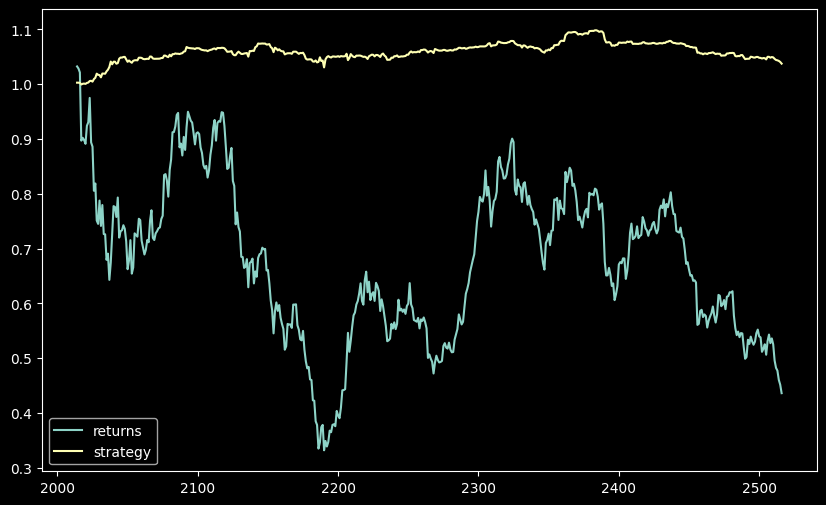

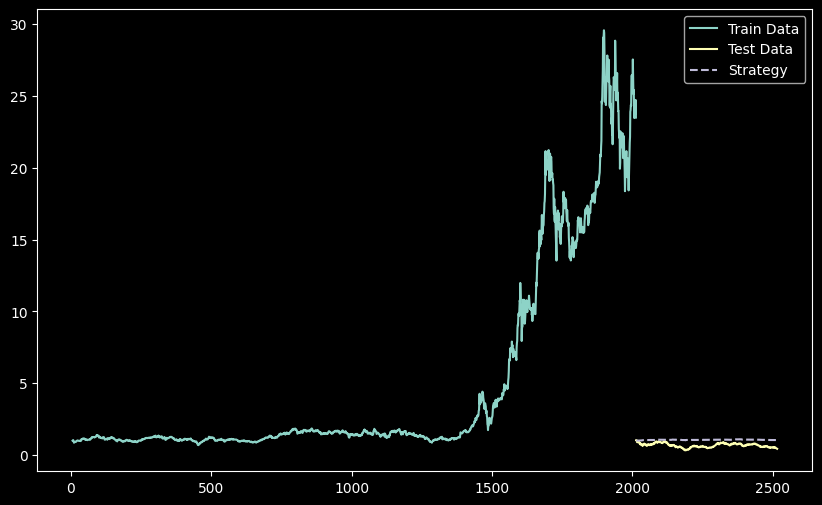

In [129]:
prediction.evaluate()

In [130]:
# np.exp(Test[['returns', 'strategy_returns']].sum())

In [131]:
# np.exp(Test[['returns', 'strategy_returns']].cumsum()).plot()